## Import libraries

In [1]:
import glob
import sys
import warnings

from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch import nn
from tqdm.auto import tqdm
import copy
import time

from IPython import display as ipd
from PIL import Image

from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder,  DatasetFolder,VisionDataset
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt
import os
import torchvision.models as models

%matplotlib inline
warnings.filterwarnings("ignore")

import torchaudio
#from pydub import AudioSegment
from IPython import display
import random
import wandb
from scipy.optimize import brentq
from scipy.interpolate import interp1d

C:\Users\79671\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\79671\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\79671\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Config

In [2]:
class CFG:
    JUST_PREDICT  = False
    Kaggle        = False 
    DEBUG         = False
    FULL_DATA     = True
    wandb_on      = False
    seed          = 101
    MULTIMODEL    = False
    weights       = 'imagenet'
    backbone      = 'efficientnet-b1'
    model_name    = 'eff_net_b1'
    archive_name  = 'Audio'
    models        = []
    optimizers    = []
################################################### 
    num_of_models = 1
    model_number  = 1
    train_bs      = 32
    valid_bs      = 32
    width         = 300 # image width
    mels          = 80  # height
    SAMPLE_RATE   = 16000
    NUM_SAMPLES   = 48000
    num_item_all  = 5000 if DEBUG else 45235     #45235
    num_test      = 10 if DEBUG else 301      # 1000
    print_every   = 1  if DEBUG else 50      #500
    epochs        = 25  if DEBUG else 90        #35
    ###############################################
    crop_koef     = 1
    lr            = 0.002
    num_workers   = 4 if Kaggle else 0
    criterion     = nn.CrossEntropyLoss()
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    num_classes   = 2
    classes       = [0,1]
    activation    = None #'softmax'
    device        = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    test_path     = " " if Kaggle else "E:/Audio/ASV/clips/"
    save_path     = '../working/result/' if Kaggle else "./result/"
    train_path    = "E:/Audio/ASV/clips/"
    csv_path      = 'E:/Audio/ASV/equal_dataset' 
    best_model_w  = 'C:/Users/79671/Desktop/ML/Deep_Fake/Important_rezulsts/Last_epoch_of_eff_net_b1.bin' if Kaggle else 'C:/Users/79671/Desktop/ML/Deep_Fake/Important_rezulsts/Last_epoch_of_eff_net_b1.bin'


In [3]:
try:
    wandb.login(key='411cb1a6772ab39c9283d4f54778064f0be42b74')
    #wandb login 411cb1a6772ab39c9283d4f54778064f0be42b74
    anonymous = None
except:
    anonymous = "must"
    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

wandb: Currently logged in as: ilyamironov210202 (kode-ai). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\79671/.netrc


In [4]:
print(CFG.device)

cuda


In [5]:
# Different classes dataset. 
classes = ('0','1')

## Read data

In [6]:

data = pd.read_csv(CFG.csv_path, sep = '\t' ) #pd.read_csv(CFG.csv_path, sep = '\\t', header=None)

In [7]:
data.head(10)

,path,fake
0,DF_E_2000053,0
1,DF_E_2000058,0
2,DF_E_2000079,0
3,DF_E_2000246,0
4,DF_E_2000503,0
5,DF_E_2000508,0
6,DF_E_2000531,0
7,DF_E_2000676,0
8,DF_E_2001149,0
9,DF_E_2001163,0


<AxesSubplot:xlabel='fake', ylabel='Count'>

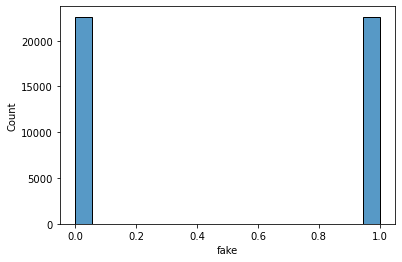

In [8]:
sns.histplot(data=data['fake'])

In [9]:
data['fake'].value_counts()

1    22618
0    22617
Name: fake, dtype: int64

In [10]:
 data.shape

(45235, 2)

In [11]:
sum(data['fake'].isnull())

0

In [12]:
#from torchaudio.io import StreamReader
from IPython import display

## Audio Augmentations

In [13]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=CFG.SAMPLE_RATE,
    n_fft=1024,
    win_length = 1024,
    hop_length=256,
    n_mels= CFG.mels,
    window_fn = torch.hann_window,
    center=False
)

MFCC_spectrogram = torchaudio.transforms.MFCC(
    sample_rate=CFG.SAMPLE_RATE,
    n_mfcc = CFG.mels,
    melkwargs={
        "n_fft": 1024,
        "n_mels": CFG.mels,
        "hop_length": 256,
        "mel_scale": "htk",
        'win_length': 1024,
        'window_fn': torch.hann_window,
        'center':False
    },
)

## Dataset class

In [14]:
class UrbanSoundDataset(Dataset):

    def __init__(self,
                 annotations_file,
                 audio_dir,
                 transformation,
                 target_sample_rate,
                 num_samples,
                lable = False):
        self.annotations = annotations_file
        self.audio_dir = audio_dir
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
        self.lable = lable

    def __len__(self):
        return len(self.audio_dir)

    def __getitem__(self, index):
        #print(index)
        audio_sample_path = self._get_audio_sample_path(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = self.transformation(signal)
        #signal = self._resample_if_necessary(signal, sr)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        #signal = signal.repeat(3, 1, 1)
        #signal = torch.squeeze(signal)
        #signal = self.transformation(signal)
        if self.lable == True: # WHEN WE TRAIN
            label = self._get_audio_sample_label(index)
            return signal, label
        else: # WHEN WE PREDICT
            return signal, torch.randint(0, 1, (1,))

    def _cut_if_necessary(self, signal):
        if signal.shape[2] > CFG.width:
            signal = signal[:, :, 0:CFG.width]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[2]
        if length_signal < CFG.width:
            num_missing_samples = CFG.width - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _get_audio_sample_path(self, index):
        path = self.audio_dir[index]
        if self.lable == True:
            path = os.path.join(CFG.train_path,path)
        else:
            path = os.path.join(CFG.test_path,path)
        path = path + '.flac'
        return path

    def _get_audio_sample_label(self, index):
        path = self.audio_dir[index]
        #print(path)
        df = self.annotations
        df = df.loc[lambda df: df['path'] == path]
        #print(df.head())
        num = list(df['fake'])
        #print(num)
        return torch.Tensor(num)




In [15]:
def prepare_loaders():
    audio_names = pd.read_csv(CFG.csv_path, sep = '\t' )
    audio_names = list(audio_names['path'])
    #audio_names= [item_name.split('.')[0] for item_name in os.listdir(CFG.train_path)] #[os.path.join("./train/",item_name)  for item_name in os.listdir(CFG.train_path)]
    random.shuffle(audio_names)
    audio_names = audio_names[:CFG.num_item_all]
    print(f'Number of items we work with:{len(audio_names)}')
    audio_train_valid, audio_test = train_test_split(audio_names, test_size=0.2 ,   random_state= CFG.seed)
    audio_train, audio_valid = train_test_split(audio_train_valid, test_size=0.25 , random_state= CFG.seed)
    #print(type(train_ids))
    #print(valid_ids)
    train_dataset = UrbanSoundDataset(data, audio_train, MFCC_spectrogram, CFG.SAMPLE_RATE, CFG.NUM_SAMPLES, True)
    valid_dataset = UrbanSoundDataset(data, audio_valid, MFCC_spectrogram, CFG.SAMPLE_RATE, CFG.NUM_SAMPLES, True)
    test_dataset  = UrbanSoundDataset(data, audio_test, MFCC_spectrogram, CFG.SAMPLE_RATE, CFG.NUM_SAMPLES, True)
    
    train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs, num_workers=0, shuffle=True, pin_memory=True, drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs, num_workers=0, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=CFG.valid_bs, num_workers=0, shuffle=False, pin_memory=True)
    return train_loader, valid_loader , test_loader

## Visualization

In [16]:
def Melspectrogram_visualize(array: torch.Tensor):
    #print(array.shape)
    plt.figure(figsize=(20, 5))
    plt.imshow(array.squeeze().log())
    plt.xlabel('Time', size=20)
    plt.ylabel('Frequency (Hz)', size=20)
    plt.show()

    
    
def visualize_audio(wav: torch.Tensor, sr: int = 22050):
    # Average all channels
    if wav.dim() == 2:
        # Any to mono audio convertion
        wav = wav.mean(dim=0)
    
    plt.figure(figsize=(20, 5))
    plt.plot(wav, alpha=.7, c='green')
    plt.grid()
    plt.xlabel('Time', size=20)
    plt.ylabel('Amplitude', size=20)
    plt.show()
    
    display.display(display.Audio(wav, rate=sr))

In [17]:
from typing import List , Tuple

In [18]:
train_loader, valid_loader, test_loader = prepare_loaders()

Number of items we work with:45235


In [19]:
len(train_loader) , len(valid_loader)

(849, 283)

In [20]:
audio = next(iter(train_loader))
#print(audio['wav'].shape)
#print(Class)


In [21]:
mel = audio[0][0]

In [22]:
mel.shape

torch.Size([1, 80, 300])

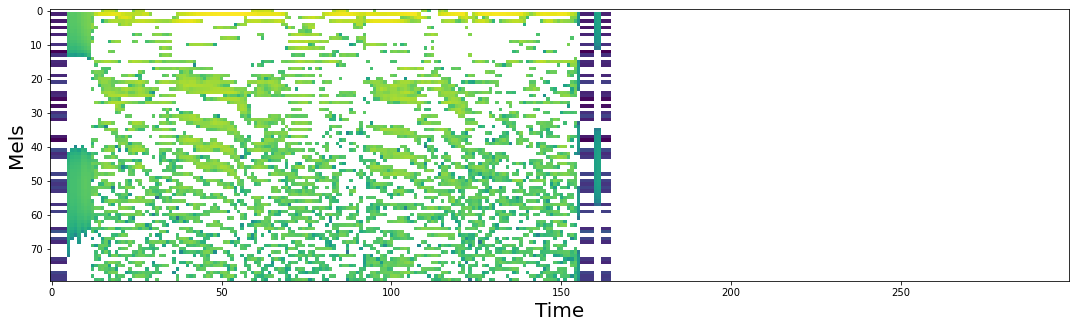

In [23]:
plt.figure(figsize=(20, 5))
plt.imshow(mel.permute(1,2,0).squeeze().log())
plt.xlabel('Time', size=20)
plt.ylabel('Mels', size=20)
plt.show()

In [24]:
mel.shape

torch.Size([1, 80, 300])

In [25]:
#Melspectrogram_visualize(audio)

In [26]:
#!pip install --upgrade efficientnet-pytorch

In [27]:
#############################################################################################################################
####################################################### BILSTM MODEL ########################################################
#############################################################################################################################
class LSTM(nn.Module):
    
    # define all the layers used in model
    def __init__(self, input_dim=80, hidden_size= 128):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_dim,
                           hidden_size=hidden_size,
                           num_layers = 1,
                           batch_first=True,
                           bidirectional = False)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.clf = nn.Linear(hidden_size, 2)
        self._fc = torch.nn.Sequential(
    nn.Linear(in_features=128, out_features=64, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=64, out_features=32, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=32, out_features=2, bias=True))
        
    def forward(self, input, length = CFG.width - 1):
        # input: (batch_size, hidden_size, seq_len)
        out, _ = self.lstm(input.transpose(-1, -2))
        out = out[:,CFG.width - 1,:]
        # output: (batch_size, seq_len, hidden_size)
        
#         last_hidden = torch.gather(
#             output,
#             dim =1,
#             index = length.sub(1).view(-1, 1, 1).expand(-1, -1, self.hidden_size)
#         )
        #logits = self.clf(last_hidden.squeeze(dim=1))
        #print(f'OUT SHAPE: {out.shape}')
        out = self._fc(out)
        return out
    

In [28]:
device = CFG.device

#from efficientnet_pytorch import EfficientNet
#model_name = 'efficientnet-b1'
#model = EfficientNet.from_pretrained(model_name).to(device)  #, num_classes=3

# for param in model.parameters():
#     param.requires_grad = False 
# model._fc = torch.nn.Sequential(
#     nn.Linear(in_features=1280, out_features=625, bias=True),
#     nn.ReLU(inplace=True),
#     nn.Dropout(p=0.5, inplace=False),
#     nn.Linear(in_features=625, out_features=256, bias=True),
#     nn.ReLU(inplace=True),
#     nn.Linear(in_features=256, out_features=2, bias=True))

model = LSTM().to(device)
#featurizer = Featurizer().to(device)
model.eval()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
#optimizer = torch.optim.Adam(model._fc.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

In [29]:
model

LSTM(
  (lstm): LSTM(80, 128, batch_first=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (clf): Linear(in_features=128, out_features=2, bias=True)
  (_fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [30]:
#pip install torch-summary

In [31]:
from torchsummary import summary
summary(model, input_size = (3,224,224))

Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              107,520
├─ReLU: 1-2                              --
├─Dropout: 1-3                           --
├─Linear: 1-4                            258
├─Sequential: 1-5                        --
|    └─Linear: 2-1                       8,256
|    └─ReLU: 2-2                         --
|    └─Dropout: 2-3                      --
|    └─Linear: 2-4                       2,080
|    └─ReLU: 2-5                         --
|    └─Linear: 2-6                       66
Total params: 118,180
Trainable params: 118,180
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              107,520
├─ReLU: 1-2                              --
├─Dropout: 1-3                           --
├─Linear: 1-4                            258
├─Sequential: 1-5                        --
|    └─Linear: 2-1                       8,256
|    └─ReLU: 2-2                         --
|    └─Dropout: 2-3                      --
|    └─Linear: 2-4                       2,080
|    └─ReLU: 2-5                         --
|    └─Linear: 2-6                       66
Total params: 118,180
Trainable params: 118,180
Non-trainable params: 0

In [32]:
# model.load_state_dict(torch.load(CFG.best_model_w , map_location=torch.device('cpu')))
# model.eval()
# model.to(CFG.device)

## Class for counting metrics

In [33]:
class AverageMeter(object):
    """
    Computes and stores the average and current value
    """
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Create directory for results

In [34]:
import shutil, os

try:
    if CFG.Kaggle:
        os.mkdir('../working/result')
        print('KAGGLE DIR CREATED')
    else:
        #shutil.rmtree('./result')
        local_time = time.ctime().replace(' ', '_').replace(':', '.')
        directory = f'../results/result_{CFG.model_name}_{local_time}'
        os.mkdir(directory)
        print('PC DIR CREATED')
except Exception:
    print("DIR NOT CREATED")
    pass

PC DIR CREATED


In [35]:
from collections import defaultdict

In [36]:
storage = defaultdict(list)

## EER CODE

In [37]:
def compute_det_curve(target_scores, nontarget_scores):

    n_scores = target_scores.size + nontarget_scores.size # sum of sizes 
    all_scores = np.concatenate((target_scores, nontarget_scores)) # vector of scores
    labels = np.concatenate((np.ones(target_scores.size), np.zeros(nontarget_scores.size))) # vextor of labels
    # Sort labels based on scores
    indices = np.argsort(all_scores, kind='mergesort') # retern indexes of sorted array of zeros and ones
    labels = labels[indices] # and sort labels like (zeros and ones) for all 0 in both arrays and (zeros + ones) of 1 in both arrays

    # Compute false rejection and false acceptance rates
    tar_trial_sums = np.cumsum(labels) # array with max element N
    # (np.arange(1, n_scores + 1, step = 1) - tar_trial_sums | gives array of element with max el = N
    nontarget_trial_sums = nontarget_scores.size - (np.arange(1, n_scores + 1, step = 1) - tar_trial_sums)

    frr = np.concatenate((np.atleast_1d(0), tar_trial_sums / target_scores.size))  # false rejection rates
    far = np.concatenate((np.atleast_1d(1), nontarget_trial_sums / nontarget_scores.size))  # false acceptance rates
    thresholds = np.concatenate((np.atleast_1d(all_scores[indices[0]] - 0.001), all_scores[indices]))  # Thresholds are the sorted scores

    return frr, far, thresholds

def compute_eer(target_scores, nontarget_scores):
    """ Returns equal error rate (EER) and the corresponding threshold. """
    frr, far, thresholds = compute_det_curve(target_scores, nontarget_scores)
    abs_diffs = np.abs(frr - far)
    min_index = np.argmin(abs_diffs) # return index of min element
    eer = np.mean((frr[min_index], far[min_index]))
    return eer, thresholds[min_index]

def minDCF(confusion_matrix):
# 0 - Real | 1 - Sintesized
# FAR - поставили 0 вместо 1 | ошибка второго рода 100% true
# FRR - поставили 1 вместо 0 | ошибка первого рода 100% true
    Pfar =  confusion_matrix[1][0] /(confusion_matrix[1][0] + confusion_matrix[0][1] + confusion_matrix[0][0] + confusion_matrix[1][1])
    Pfrr =  confusion_matrix[0][1] /(confusion_matrix[1][0] + confusion_matrix[0][1] + confusion_matrix[0][0] + confusion_matrix[1][1])
    mDCF = (0.01 * Pfar + 0.1 * Pfrr) * 100
    return mDCF


## Создание файла для ведения статистики

In [38]:
f = open(f'{directory}/Stats', 'w')

In [39]:
#f.write('\n\n\n')

# Wandb

In [40]:

if not CFG.DEBUG:
    run = wandb.init(project='LSTM',                      
                          anonymous=anonymous,
                          name=f"MODEL: LSTM 3 layers, Epochs: {CFG.epochs}, Samples: {CFG.num_item_all} ",                  
                         )
    
    wandb.config.epochs = CFG.epochs
    wandb.config.train_batch_size = CFG.train_bs
    wandb.config.valid_batch_sizw = CFG.valid_bs
    wandb.config.samples = CFG.num_item_all
    wandb.config.Debug = CFG.DEBUG
    wandb.config.sr = CFG.SAMPLE_RATE
    wandb.config.lr = CFG.lr



# Training of model

In [41]:
best_accuracy = 0
for epoch in range(1, CFG.epochs + 1):
    print(f'Epoch: {epoch}/{CFG.epochs}')
    f.write(f'Epoch: {epoch}')
    f.write('\n')
    train_loss_meter = AverageMeter()
    model.train()
####################################################################################################################
################################################## TRAINING ########################################################
####################################################################################################################


    for i, batch in enumerate(tqdm(train_loader)):
        # Move batch to device if device != 'cpu'
        wav = batch[0].to(device)
        #length = batch['length'].to(device)
        label = batch[1].to(device)
        label = label.reshape(len(label))
        label = torch.tensor(label).long()
        #print(f'label:{label}')
        wav = wav.squeeze()
        #print(wav.shape)
        #mel, mel_length = featurizer(wav, length)
        output = model(wav)
        #print(output.shape)
        #print(f'output :{output.argmax(dim=-1).shape}')
        
        #print(f'label: {label.shape}')
        loss = criterion(output, label) # need class probabitities
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss_meter.update(loss.item())
        
    storage['train_loss'].append(train_loss_meter.avg)
    
    
###################################################################################################################
#############################################  Validation  ########################################################
###################################################################################################################
    full_vec = []
    full_labels = []
    validation_loss_meter = AverageMeter()
    validation_accuracy_meter = AverageMeter()
    validation_f1_meter = AverageMeter()
    validation_EER_meter = AverageMeter()
    validation_MinDCF_meter = AverageMeter()
    all_matrix = [[0,0],[0,0]]
    model.eval()
    for i, batch in enumerate(tqdm(valid_loader)):
        # Move batch to device if device != 'cpu'
        wav = batch[0].to(device)
        #length = batch['length'].to(device)
        label = batch[1].to(device)
        label = label.reshape(len(label))
        label = torch.tensor(label).long()
        wav = wav.squeeze()
        with torch.no_grad():
            output = model(wav)
            loss = criterion(output, label)
            out2 = output.softmax(dim=1)
            out2 = out2.transpose(0,1)
            out2 = out2[1][:]
            out2 = out2.cpu().numpy()
            out = output.argmax(dim=-1).cpu().numpy()
            labels = label.cpu().numpy()
            full_vec.extend(out2)
            full_labels.extend(labels)
        #print(f'output :{output.argmax(dim=-1)}, label : {label}')
        
        matches = (output.argmax(dim=-1) == label).float().mean()
        f1 = f1_score(output.argmax(dim=-1).cpu(), label.cpu(), average= 'weighted')
        #print(f'Vallid:{matches.item()}')
        
        validation_loss_meter.update(loss.item(),        len(batch[0]))
        validation_accuracy_meter.update(matches.item(), len(batch[0]))
        #validation_EER_meter.update(eer[0],              len(batch[0]))
        validation_f1_meter.update(f1,                   len(batch[0]))
        
        
        matrix = confusion_matrix(labels,out)
        all_matrix+=matrix
        #print(f'F1 :{f1} , EER: {eer}')
        #print(f'Confusion Matrix of all:{all_matrix}')\
######################################## SAVE MODEL ###########################################################################

    if validation_accuracy_meter.avg > best_accuracy:
        print(f'Validation_accuracy improved from {best_accuracy} ---> {validation_accuracy_meter.avg} !')
        PATH = f"{directory}/Best_epoch_of_{CFG.model_name}.bin"
        torch.save(model.state_dict(), PATH)
        best_accuracy = validation_accuracy_meter.avg
 ###############################################################################################################################        


    
    #display.clear_output()
    mDCF = minDCF(all_matrix)
    validation_MinDCF_meter.update(mDCF)
    
    
    print(f'Confusion Matrix of all:{all_matrix}')
    print(f'minDCF : {mDCF}% ')
    plt.title('ROC CURVE WITH EER')
    fpr, tpr, _ = metrics.roc_curve(full_labels,  full_vec)
    EER = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.) * 100
    print(f'EER : {EER}%')
    
    auc = metrics.roc_auc_score(full_labels,  full_vec)
    plt.plot(fpr,tpr,label = 'AUC = %0.3f' % auc) #"AUC=%0.2f' %"+str(auc)+ '%')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.plot([0, 1], [1, 0],'r--', label = 'EER')
    plt.plot([0, 1], [0, 1],'p--', label = 'Random Classifier')
    plt.legend(loc=4)
    plt.show()
    
    
    storage['validation_loss'].append(validation_loss_meter.avg)
    storage['validation_accuracy'].append(validation_accuracy_meter.avg)
    storage['validation_F1_score'].append(validation_f1_meter.avg)
    storage['validation_EER'].append(EER)
    f.write('Validation_Loss: '+ str(validation_loss_meter.avg) + '\n')
    f.write('Validation accuracy: ' + str(validation_accuracy_meter.avg) + '\n')
    f.write('Validation_f1: '+str(validation_f1_meter.avg) + '\n')
    f.write('Validation_EER: '+str(EER) + '\n')
    f.write('Validation_MinDCF: '+ str(validation_MinDCF_meter.avg) + '%\n')
    f.write('\n\n')
    
    
    wandb.log({"Train Loss": train_loss_meter.avg, 
            "Valid Loss": validation_loss_meter.avg,
            "Valid Accuracy": validation_accuracy_meter.avg,
            "Validation F1 score": validation_f1_meter.avg,
            "Validation EER": EER,
            "Valiation mDCF":validation_MinDCF_meter.avg,
            "EER" : EER })  
############################################## PLOT ###################################################################### 
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))

    axes[0].plot(storage['train_loss'], label='train_loss')
    axes[1].plot(storage['validation_loss'], label='validation_loss')
    axes[2].plot(storage['validation_accuracy'], label='validation_accuracy')
    axes[3].plot(storage['validation_F1_score'], label='validation_F1_score')
    axes[4].plot(storage['validation_EER'], label='EER')
    for i in range(5):
        axes[i].grid()
        axes[i].legend()

    plt.show()
################### Save Last Epoch ##########################################
best_model_wts = copy.deepcopy(model.state_dict())
PATH = f"./{directory}/Last_epoch_of_{CFG.model_name}.bin"
torch.save(model.state_dict(), PATH)

Epoch: 1/90


  0%|          | 0/849 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
run.finish()

In [ ]:
best_model_wts = copy.deepcopy(model.state_dict())
PATH = f"./result/Last_epoch_of_{CFG.model_name}.bin"
torch.save(model.state_dict(), PATH)

# Test trained Model

In [ ]:
test_loss_meter = AverageMeter()
test_accuracy_meter = AverageMeter()
test_f1_meter = AverageMeter()
test_EER_meter = AverageMeter()
all_matrix = [[0,0],[0,0]]
full_vec = []
full_labels = []
for i, batch in enumerate(tqdm(test_loader)):
        # Move batch to device if device != 'cpu'
        wav = batch[0].to(device)
        #length = batch['length'].to(device)
        label = batch[1].to(device)
        label = label.reshape(len(label))
        label = torch.tensor(label).long()
        wav = wav.squeeze()
        with torch.no_grad():
            output = model(wav)
            out = output.argmax(dim=-1).cpu().numpy()
            out2 = output.softmax(dim=1)
            out2 = out2.transpose(0,1)
            out2 = out2[1][:]
            out2 = out2.cpu().numpy()
            labels = label.cpu().numpy()
            full_vec.extend(out2)
            full_labels.extend(labels)
        #print(f'output :{output.argmax(dim=-1)}, label : {label}')
        
        matches = (output.argmax(dim=-1) == label).float().mean()
        f1 = f1_score(output.argmax(dim=-1).cpu(), label.cpu(), average= 'weighted')
        eer = compute_eer(labels,out)
        #print(f'Test:{matches.item()}')
        
        test_loss_meter.update(loss.item(),        len(batch[0]))
        test_accuracy_meter.update(matches.item(), len(batch[0]))
        #test_EER_meter.update(eer[0],              len(batch[0]))
        test_f1_meter.update(f1,                   len(batch[0]))
        
        
        matrix = confusion_matrix(labels,out)
        all_matrix+=matrix
        #print(f'F1 :{f1} , EER: {eer}')
        #print(f'Confusion Matrix of all:{all_matrix}')\
        
mDCF = minDCF(all_matrix)
validation_MinDCF_meter.update(mDCF)


print(f'Confusion Matrix of all:{all_matrix}')
print(f'minDCF : {mDCF}% ')
plt.title('ROC CURVE WITH EER')
fpr, tpr, _ = metrics.roc_curve(full_labels,  full_vec)
EER = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.) * 100
print(f'EER : {EER}%')

auc = metrics.roc_auc_score(full_labels,  full_vec)
plt.plot(fpr,tpr,label = 'AUC = %0.3f' % auc) #"AUC=%0.2f' %"+str(auc)+ '%')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [1, 0],'r--', label = 'EER')
plt.plot([0, 1], [0, 1],'p--', label = 'Random Classifier')
plt.legend(loc=4)
plt.show()


f.write('test_Loss: '+ str(test_loss_meter.avg) + '\n')
f.write('test accuracy: ' + str(test_accuracy_meter.avg) + '\n')
f.write('test_f1: '+str(test_f1_meter.avg) + '\n')
f.write('test_EER: '+str(EER) + '\n')
f.write('Validation_MinDCF: '+ str(validation_MinDCF_meter.avg) + '%\n')
f.write('\n\n')
#display.clear_output()
print(f'Confusion Matrix of all:{all_matrix}')
print(f'Accuracy on Test Dataset:{test_accuracy_meter.avg} !')

In [ ]:
f.close()

In [ ]:
matrix

In [ ]:
all_matrix = [[0,0],[0,0]]

In [ ]:
all_matrix+=matrix

In [ ]:
all_matrix


In [ ]:
storage['validation_F1_score']
    

In [ ]:
f1_score(out.cpu(),label.cpu(),average='weighted')

In [ ]:
#fit(model, CFG.epochs , train_loader, valid_loader, optimizer, CFG.criterion, CFG.device)

## Efficcient_net predict

In [ ]:
#test = []
'./test/'
items_names= [item_name.split('.')[0] for item_name in os.listdir(CFG.test_path)]#os.path.join("./test",item_name)
test_dataset = UrbanSoundDataset(data, items_names, mel_spectrogram, CFG.SAMPLE_RATE, CFG.NUM_SAMPLES, False)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=0, shuffle=False, pin_memory=True, drop_last=False,collate_fn=Collator())


In [ ]:
test = []
for i, batch in enumerate(tqdm(test_loader)):
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device)
        length = batch['length'].to(device)
        label = batch['label'].to(device)

        with torch.no_grad():

            mel, mel_length = featurizer(wav, length)
            output = model(mel, mel_length)
            #print(output)
            _, pred = torch.max(output, 1) # Return values and indices
            #m = nn.Softmax(dim=1)
            #pred = m(output)
            #print(pred)
            #print(pred.item())
            #df
            test.append(classes[pred.item()])
#print(test)

In [ ]:
print(len(test))

In [ ]:
items_names= [item_name.split('.')[0] for item_name in os.listdir(CFG.test_path)]

In [ ]:
df = pd.DataFrame({"id" :items_names,
                   "eff": test
        
                  })

In [ ]:
df.head(2)

In [ ]:

ansamble_pred = df['eff'].to_numpy()

In [ ]:
#df.to_csv?

In [ ]:
print('Generating submission file...')
#os.chdir("./")
df.to_csv('answers.tsv',index=False, sep = '\t',header = False)

In [ ]:
# df = pd.DataFrame({"id" : range(1,250),
#                    "class": ansamble_pred
# #                   }

In [ ]:
# df = pd.DataFrame({"id" : range(1,250),
#                    "class": test
#                   })

In [ ]:
# df["class"]

In [ ]:
# df.tail(50)

In [ ]:
# df_full.tail(50)

In [ ]:
# print('Generating submission file...')
#os.chdir("./")
# df.to_csv('submission_audio.csv',index=False)

In [ ]:
# df_full.to_csv('submission_effnet7new2.csv',index=False)